In [30]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [31]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.005

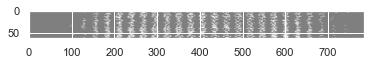

In [33]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [34]:
class FCNClass(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass, self).__init__()

        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 3 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden3 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 4 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.output = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)


    def forward(self, x):
        midLevel = self.hidden1(x)
        midLevel = self.hidden2(midLevel)
        midLevel = self.hidden3(midLevel)
        output   = self.output(midLevel)
        return output


In [36]:
model = FCNClass().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.9)
opt = "Nesterov"

In [37]:
train_loss_history = []
valid_loss_history = []
epochs = []
n_total_steps = len(train_loader)
train_loss_average = torch.zeros(num_epochs)
valid_loss_average = torch.zeros(num_epochs)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)
start_time = time.time()

Epoch 0	             Training Loss: 2.109543309155812	             Validation Loss:1.4884582902215848	             LR:0.005
Epoch 1	             Training Loss: 1.7427645647195356	             Validation Loss:1.0062246144197549	             LR:0.005
Epoch 2	             Training Loss: 1.5998180400588111	             Validation Loss:0.8464848552919497	             LR:0.005
Epoch 3	             Training Loss: 1.5468597853107493	             Validation Loss:0.7541163409971128	             LR:0.005
Epoch 4	             Training Loss: 1.5134430121002929	             Validation Loss:0.6887859028236122	             LR:0.005
Epoch 5	             Training Loss: 1.5015562398474354	             Validation Loss:0.6870789144449173	             LR:0.005
Epoch 6	             Training Loss: 1.4812801480293274	             Validation Loss:0.6469145783573199	             LR:0.005
Epoch 7	             Training Loss: 1.4637823109306507	             Validation Loss:0.6345669528481307	             LR:0.005
E

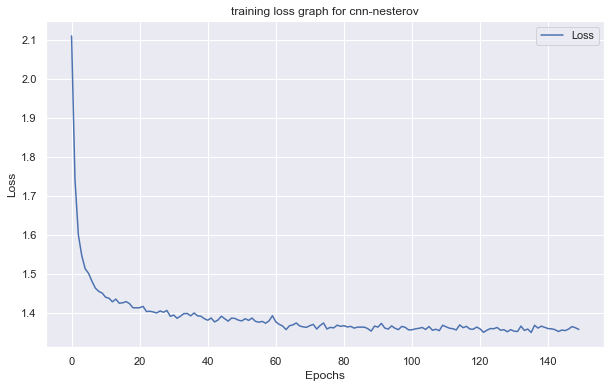

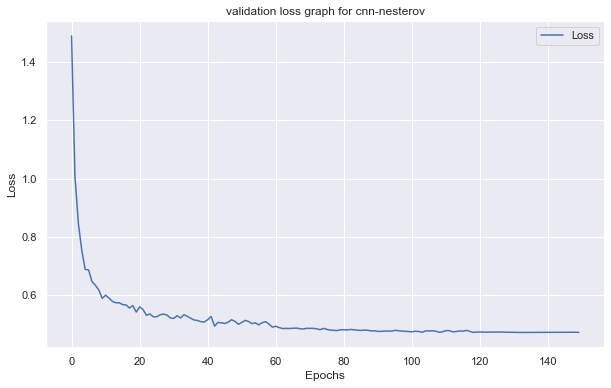

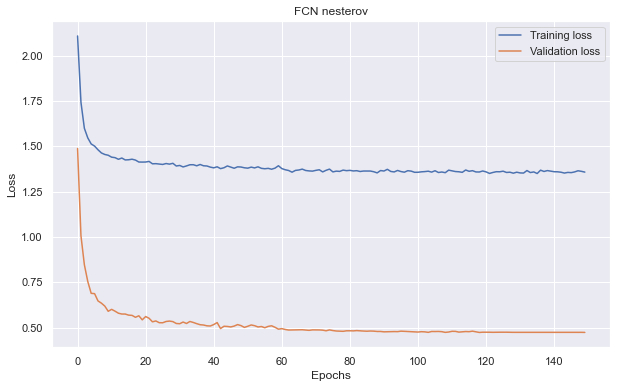

In [38]:
start_time = time.time()
for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_valid_loss = 0.0
    #trainng loop
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        train_step_loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        train_step_loss.backward()
        optimizer.step()

        running_train_loss += train_step_loss.item()

    #get the training losses
    train_loss_average[epoch] = running_train_loss/len(train_loader)
    train_loss_history.append(train_step_loss.item())

    #validation loop
    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        valid_step_loss = criterion(outputs, labels)

        running_valid_loss += valid_step_loss.item()

    #get the validation losses
    valid_loss_average[epoch] = running_valid_loss/len(test_loader)
    valid_loss_history.append(valid_step_loss.item())
    epochs.append(epoch)

    #get the current learning rate
    curr_lr = optimizer.param_groups[0]['lr']

    #step the learning rate scheduler
    scheduler.step()

    print(f'Epoch {epoch}\t \
            Training Loss: {running_train_loss/len(train_loader)}\t \
            Validation Loss:{running_valid_loss/len(test_loader)}\t \
            LR:{curr_lr}')

print("--- %s seconds ---" % (time.time() - start_time))
print('Finished Training')


In [39]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')



Accuracy of the network on the 10000 test images: 86.14 %


In [ ]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(title + '.png')

In [ ]:
#plot the loss diagrams
plotLosses(epochs, train_loss_average, f'train_loss_FCN-{opt} lr:{learning_rate} acc:{acc}')
plotLosses(epochs, valid_loss_average, f'valid_loss_FCN-{opt} lr:{learning_rate} acc:{acc}')

plt.figure(figsize=(10,6))
plt.title(f'FCN-{opt} lr:{learning_rate} acc:{acc}')
plt.plot(epochs, train_loss_average, label = "Training loss")
plt.plot(epochs, valid_loss_average, label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f'FCN-{opt} lr:{learning_rate} acc:{acc}.png')


PATH = f'./FCN-{opt}-lr:{learning_rate}-acc:{acc}.pth'
torch.save(model.state_dict(), PATH)